100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 540kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.42MB/s]
/workspaces/non-avian-ml/.pixi/envs/default/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/non-avian-ml/.pixi/envs/default/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Training ResNet with K-Fold...

~~~ Fold 1 Training ~~~


Fold 1 Evaluation: 100%|██████████| 417/417 [00:52<00:00,  7.88it/s]


Fold 1 Accuracy: 11.16%

~~~ Fold 2 Training ~~~


Fold 2 Evaluation: 100%|██████████| 417/417 [00:53<00:00,  7.82it/s]


Fold 2 Accuracy: 10.71%

~~~ Fold 3 Training ~~~


Fold 3 Evaluation: 100%|██████████| 417/417 [00:54<00:00,  7.66it/s]


Fold 3 Accuracy: 11.70%

Mean Accuracy Across Folds: 11.19%

Training MobileNet with K-Fold...

~~~ Fold 1 Training ~~~


Fold 1 Evaluation: 100%|██████████| 417/417 [00:18<00:00, 22.69it/s]


Fold 1 Accuracy: 10.23%

~~~ Fold 2 Training ~~~


Fold 2 Evaluation: 100%|██████████| 417/417 [00:19<00:00, 21.28it/s]


Fold 2 Accuracy: 10.11%

~~~ Fold 3 Training ~~~


Fold 3 Evaluation: 100%|██████████| 417/417 [00:18<00:00, 22.53it/s]


Fold 3 Accuracy: 10.38%

Mean Accuracy Across Folds: 10.24%


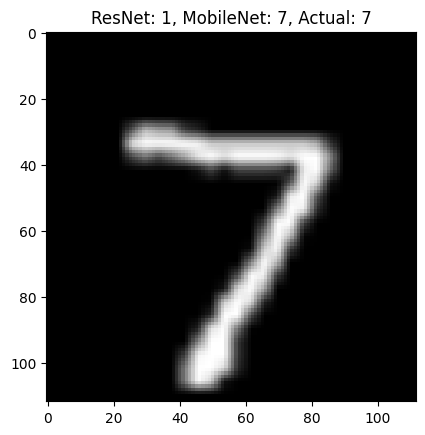

In [1]:
#super low accuracy -- need teammates' input
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from sklearn.model_selection import KFold
import numpy as np
import random
from tqdm import tqdm  # Import tqdm for progress bars

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reduce Image Size for MNIST
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # Smaller than 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST (Using only 10,000 images instead of full 60,000)
full_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
subset_indices = random.sample(range(len(full_dataset)), 10000)  # Pick 10,000 random samples
dataset = Subset(full_dataset, subset_indices)

test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Load Models
def get_resnet():
    resnet = models.resnet18(pretrained=False)
    resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    resnet.fc = nn.Linear(resnet.fc.in_features, 10)
    return resnet.to(device)

def get_mobilenet():
    mobilenet = models.mobilenet_v2(pretrained=False)
    mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)
    return mobilenet.to(device)

# K-Fold Cross Validation (With Smaller Batch Size)
def k_fold_train(model, dataset, n_splits=3, batch_size=8, epochs=0.5):  # Reduced epochs
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
        print(f"\n~~~ Fold {fold + 1} Training ~~~")

        train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

        # Training Loop
        model.train()
        for epoch in range(int(epochs)):  # Convert float to int for the number of epochs
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{int(epochs)}"):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation Loop (without gradient calculation)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Fold {fold+1} Evaluation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        fold_accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%")

    print(f"\nMean Accuracy Across Folds: {np.mean(fold_accuracies):.2f}%")

# Train ResNet & MobileNet
resnet = get_resnet()
print("\nTraining ResNet with K-Fold...")
k_fold_train(resnet, dataset)

mobilenet = get_mobilenet()
print("\nTraining MobileNet with K-Fold...")
k_fold_train(mobilenet, dataset)

# Save models
torch.save(resnet.state_dict(), "resnet_mnist_kfold.pth")
torch.save(mobilenet.state_dict(), "mobilenet_mnist_kfold.pth")

# Test on a Single Image
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)

predicted_class_resnet = resnet(image).argmax(1).item()
predicted_class_mobilenet = mobilenet(image).argmax(1).item()

import matplotlib.pyplot as plt
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.title(f"ResNet: {predicted_class_resnet}, MobileNet: {predicted_class_mobilenet}, Actual: {label}")
plt.show()
